In [3]:
import numpy as np #для матричных вычислений
import pandas as pd
import seaborn as sns #для визуализации
import matplotlib.pyplot as plt #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna
import warnings

%matplotlib inline
plt.style.use('seaborn')

C:\Users\johno\AppData\Local\Temp\ipykernel_9400\3366942952.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
data = pd.read_csv('C:\VS Code\_train_sem09__1_/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Разделим исходный набор данных на матрицу наблюдений X и столбец ответов y. 

In [5]:
y = data['Activity']
X = data.drop(['Activity'], axis=1)

Смотрим на сбалансированность классов:

In [6]:
data.Activity.value_counts(normalize=True) * 100

Activity
1    54.22554
0    45.77446
Name: proportion, dtype: float64

<Axes: xlabel='Activity', ylabel='count'>

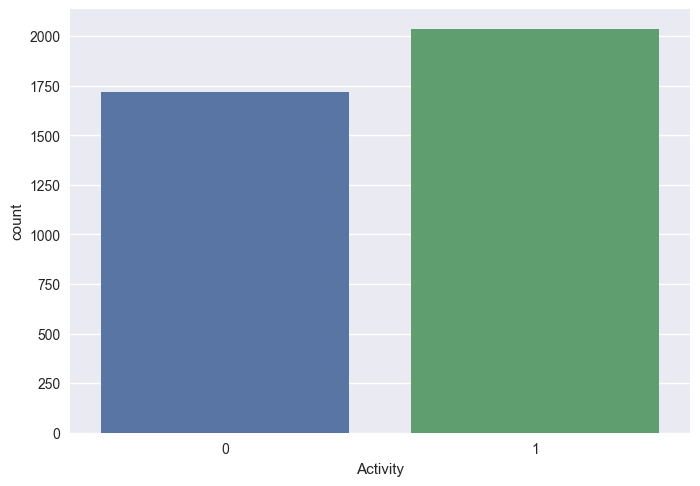

In [7]:
sns.countplot(data=data, x='Activity')

В целевом признаке Activity значения распределились с небольшим перевесом 1 - 54.22%, 0 - 45.78%. Можно не использовать параметр   stratify при разбиении на обучающую и тренировачную выборки.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [9]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))


y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.89
f1_score на тестовом наборе: 0.78


#### **Дерево решений**

Проделаем аналогичное для DecisionTreeClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [10]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.75


#### **Случайный лес**

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [11]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.80


### <center> **GridSearchCV**

#### **Логистическая регрессия**

In [12]:
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1] # уровень силы регурялизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 

y_train_pred = grid_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 58 s
Wall time: 17min 35s
f1_score на обучающем наборе: 0.82
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


#### **Дерево решений**

In [36]:
param_grid = {'min_samples_leaf': [5, 7, 9],
              'max_depth': list(np.linspace(1, 40, 10, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train, y_train)
y_train_pred = grid_search_tree.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred))) 

y_test_pred = grid_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 2.23 s
Wall time: 1min 25s
f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}


#### **Случайный лес**

In [32]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5, 7],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 10.5 s
Wall time: 2min 55s
f1_score на обучающем наборе: 0.94
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


### <center> **RandomizedSearchCV**

#### **Логистическая регрессия**

In [13]:
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 

y_train_pred = random_search.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 6.36 s
Wall time: 4min 26s
f1_score на обучающем наборе: 0.86
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.12}


#### **Дерево решений**

In [14]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train, y_train) 

y_train_pred = random_search_tree.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = random_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: total: 2.11 s
Wall time: 49.2 s
f1_score на обучающем наборе: 0.80
f1_score на тестовом наборе: 0.76
Наилучшие значения гиперпараметров: {'min_samples_leaf': 65, 'max_depth': 3, 'criterion': 'gini'}


#### **Случайный лес**

In [15]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 6.58 s
Wall time: 1min 9s
f1_score на обучающем наборе: 0.95
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 22}


### <center> Hyperopt

#### **Дерево решений**

In [16]:
# зададим пространство поиска гиперпараметров
space_tree={'min_samples_leaf': hp.choice('min_samples_leaf', list(np.linspace(5, 100, 50, dtype=int))),
       'max_depth' : hp.choice('max_depth', list(np.linspace(1, 30, 50, dtype=int))),
       'criterion': hp.choice('criterion', ['entropy','gini'])
      }

In [17]:
random_state = 42
def hyperopt_tr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'min_samples_leaf': int(params['min_samples_leaf']), 
              'max_depth': int(params['max_depth']), 
             'criterion': str(params['criterion'])
              }
  
    # используем эту комбинацию для построения модели
    model = tree.DecisionTreeClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [18]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_tr, # наша функция 
          space=space_tree, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:44<00:00,  2.25s/trial, best loss: -0.794451169881697] 
Наилучшие значения гиперпараметров {'criterion': 1, 'max_depth': 44, 'min_samples_leaf': 34}
CPU times: total: 17.4 s
Wall time: 45 s


In [19]:
crit = ['entropy','gini']
# рассчитаем точность для тестовой выборки
model = tree.DecisionTreeClassifier(
    random_state=random_state, 
    min_samples_leaf=int(best['min_samples_leaf']),
    max_depth=int(best['max_depth']),
    criterion= crit[best['criterion']] 
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.76


#### **Случайный лес**

In [20]:
# зададим пространство поиска гиперпараметров
space_forest={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [21]:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [22]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space_forest, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [01:29<00:00,  4.47s/trial, best loss: -0.9868380777471687]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: total: 1min 28s
Wall time: 1min 29s


In [23]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.81


## <center> Optuna

#### **Логистическая регрессия**

In [24]:
def optuna_lg(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
  C = trial.suggest_categorical('C', [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1])

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=float(C),
                                         random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [25]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lg, n_trials=20)

[I 2023-11-06 15:33:27,689] A new study created in memory with name: LogisticRegression
c:\Python 3.9.10\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2023-11-06 15:33:34,232] Trial 0 finished with value: 0.8832271762208068 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.7}. Best is trial 0 with value: 0.8832271762208068.
c:\Python 3.9.10\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Python 3.9.10\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Python 3.9.10\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

CPU times: total: 1min 29s
Wall time: 54.7 s


In [26]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.01}
f1_score на обучающем наборе: 0.91


In [27]:
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

c:\Python 3.9.10\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Python 3.9.10\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


f1_score на тестовом наборе: 0.76


c:\Python 3.9.10\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### **Случайный лес**

In [28]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [29]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-11-06 15:34:23,520] A new study created in memory with name: RandomForestClassifier


[I 2023-11-06 15:34:28,460] Trial 0 finished with value: 0.9030303030303032 and parameters: {'n_estimators': 185, 'max_depth': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9030303030303032.
[I 2023-11-06 15:34:33,476] Trial 1 finished with value: 0.8938241557651354 and parameters: {'n_estimators': 197, 'max_depth': 25, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9030303030303032.
[I 2023-11-06 15:34:38,710] Trial 2 finished with value: 0.9545870161536117 and parameters: {'n_estimators': 162, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9545870161536117.
[I 2023-11-06 15:34:44,250] Trial 3 finished with value: 0.9228432563791009 and parameters: {'n_estimators': 187, 'max_depth': 20, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.9545870161536117.
[I 2023-11-06 15:34:49,058] Trial 4 finished with value: 0.8954407294832826 and parameters: {'n_estimators': 182, 'max_depth': 21, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.9

CPU times: total: 1min 33s
Wall time: 1min 36s


In [30]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 135, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.80


## <center> Вывод

В даной работе были изучены и применены на практике методы оптимизации гиперпараметров модели. 
- GridSeachCV
- RandomizedSearchCV
- Hyperopt
- Optuna


Модели для которых была применена оптимизация параметров:
-  Логистическая регрессия
-  Дерево решений
-  Случайный лес

Помимо расчета метрик с оптимальными параметрами модлей, были также расчитаны модели с дефолтными параметрами для сравнения результатов. В качестве метрики  используется F1-score. Результаты на тестовом наборе получились следующие:
1. Логистическая регрессия:
 * Параметры по умолчанию - 0.78
 * GridSeachCV - 0.78
 * RandomizedSearchCV - 0.79
 * Optuna - 0.76

2. Дерево решений: 
 * Параметры по умолчанию - 0.75
 * GridSeachCV - 0.78
 * RandomizedSearchCV - 0.76
 * Hyperopt - 0.76 

3. Случайный лес:
 * Параметры по умолчанию - 0.80
 * GridSeachCV - 0.80
 * RandomizedSearchCV - 0.80
 * Hyperopt - 0.81
 * Optuna - 0.80

Логистическая регрессия лучше всего пказал метод оптимизации параметров -  RandomizedSearchCV.
Дерево решений - GridSeachCV. Случайный лес - Hyperopt. Из всех протестированных модлейЭ лучше показал Случайный лес с методом оптимизации параметров Hyperopt.